In [1]:
import sys, os; sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')))
#import os; os.chdir(os.path.dirname(os.getcwd()))
from utils.model_loader import get_model_fits
import numpy as np
import pandas as pd
import re
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt



/Users/augustarnstad/Documents/source_code/prior_paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
from numpy.linalg import eigh
from scipy.stats import norm

def nearest_correlation_matrix(A, eps=1e-8, max_iter=5):
    """
    Higham-style projection:
    1) symmetrize
    2) eigen-decompose and clip negative eigenvalues
    3) renormalize to unit diagonal (correlation)
    Repeat a few times for stability.
    """
    X = (A + A.T) / 2
    for _ in range(max_iter):
        # Eigen clip
        w, V = eigh(X)
        w_clipped = np.maximum(w, eps)
        X = (V * w_clipped) @ V.T
        # Force exact symmetry
        X = (X + X.T) / 2
        # Scale to correlation
        d = np.sqrt(np.clip(np.diag(X), eps, None))
        Dinv = np.diag(1.0 / d)
        X = Dinv @ X @ Dinv
        X = (X + X.T) / 2
        np.fill_diagonal(X, 1.0)
    return X

def spearman_to_gaussian_corr(S):
    """
    Map a Spearman correlation matrix S to the Gaussian copula
    correlation matrix R via R_ij = 2 sin(pi * S_ij / 6).
    """
    S = np.asarray(S)
    if S.shape[0] != S.shape[1]:
        raise ValueError("S must be square.")
    R = 2.0 * np.sin(np.pi * S / 6.0)
    np.fill_diagonal(R, 1.0)
    return R

def sample_gaussian_copula_uniform(n, S, random_state=None):
    """
    Sample n rows of U ~ Gaussian copula with target Spearman matrix S.
    Returns an (n, d) array with uniform(0,1) marginals.
    """
    rng = np.random.default_rng(random_state)
    d = S.shape[0]
    # Map Spearman -> Gaussian copula correlation
    R0 = spearman_to_gaussian_corr(S)
    # Project to nearest valid correlation matrix
    R = nearest_correlation_matrix(R0)
    # Cholesky (add tiny jitter if needed)
    jitter = 0
    for _ in range(3):
        try:
            L = np.linalg.cholesky(R + jitter * np.eye(d))
            break
        except np.linalg.LinAlgError:
            jitter = 1e-10 if jitter == 0 else jitter * 10
    # Sample MVN(0, R)
    Z = rng.standard_normal(size=(n, d)) @ L.T
    # Push through Phi to get uniforms
    U = norm.cdf(Z)
    return U, R  # returning R lets you inspect the actual copula correlation used

# --- Example 1: 10 variables with a simple AR(1)-style target in Spearman space ---
d = 10
rho_S = 0.6  # Spearman correlation at lag 1
S_AR = np.fromfunction(lambda i, j: rho_S**np.abs(i-j), (d, d))
np.fill_diagonal(S_AR, 1.0)

#U, R_used = sample_gaussian_copula_uniform(n=5000, S=S_AR, random_state=42)

# U is (5000, 10) with uniform marginals and the Gaussian copula specified by R_used
# If you want different marginals, say Exp(1) for col 0, Beta(2,5) for col 1, etc.:
# from scipy.stats import expon, beta
# X0 = expon.ppf(U[:, 0], scale=1.0)
# X1 = beta.ppf(U[:, 1], a=2, b=5)
# ...and so on for each column

# --- Example 2: “varying” pairwise Spearman structure (blocks + custom entries) ---
S_custom = np.eye(d)
# Block 1 (vars 0..4): high Spearman, 0.7
for i in range(0, 3):
    for j in range(i+1, 3):
        S_custom[i, j] = S_custom[j, i] = 0.8
# Block 2 (vars 5..9): moderate Spearman, 0.4
for i in range(5, 10):
    for j in range(i+1, 10):
        S_custom[i, j] = S_custom[j, i] = -0.5
# Cross-block weaker, 0.15
for i in range(0, 5):
    for j in range(5, 10):
        S_custom[i, j] = S_custom[j, i] = 0.15
# A couple of bespoke pairs:
S_custom[0, 9] = S_custom[9, 0] = 0.4
S_custom[2, 7] = S_custom[7, 2] = 0.9  # very strong (will be projected if infeasible)
S_custom[3, 4] = S_custom[4, 3] = -0.9  # very strong (will be projected if infeasible)
S_custom[1, 6] = S_custom[6, 1] = -0.9  # very strong (will be projected if infeasible)

U2, R_used2 = sample_gaussian_copula_uniform(n=10000, S=S_custom, random_state=123)


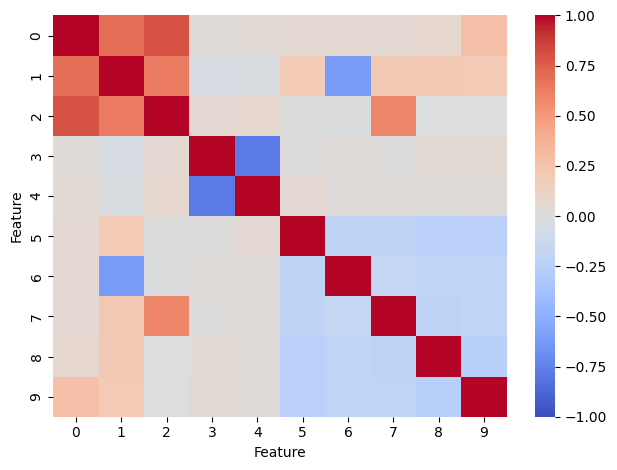

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
sns.heatmap(np.corrcoef(U2, rowvar=False), vmin=-1, vmax=1, cmap='coolwarm')
plt.xlabel("Feature")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("figures_for_use_in_paper/friedman_correlation_structure.pdf", bbox_inches="tight")
plt.show()


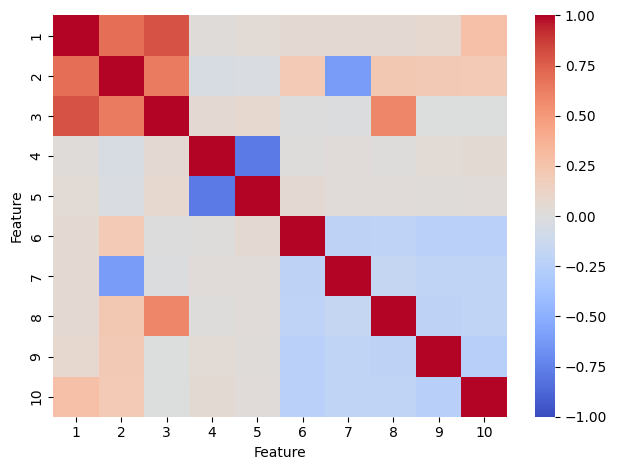

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

corr = np.corrcoef(U2, rowvar=False)

plt.figure()
ax = sns.heatmap(corr, vmin=-1, vmax=1, cmap='coolwarm')

# Number of features
n = corr.shape[0]

# Set tick labels to 1..n
ax.set_xticks(np.arange(n) + 0.5)
ax.set_yticks(np.arange(n) + 0.5)
ax.set_xticklabels(np.arange(1, n+1))
ax.set_yticklabels(np.arange(1, n+1))

plt.xlabel("Feature")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [8]:
from sklearn.model_selection import train_test_split

def generate_correlated_Friedman_data(U, N=100, D=10, sigma=1.0, test_size=0.2, seed=42, standardize_y=True):
    """
    Generate synthetic regression data for Bayesian neural network experiments.

    Parameters:
        N (int): Number of samples.
        D (int): Number of features.
        sigma (float): Noise level.
        test_size (float): Proportion for test split.
        seed (int): Random seed.
        standardize_y (bool): Whether to standardize the response variable.

    Returns:
        tuple: (X_train, X_test, y_train, y_test, y_mean, y_std) if standardize_y,
               else (X_train, X_test, y_train, y_test)
    """
    np.random.seed(seed)
    #X = np.random.uniform(0, 1, size=(N, D))
    if N != U.shape[0]:
        idx = np.random.choice(U.shape[0], size=N, replace=False)
        X = U[idx, :]
    else:
        X = U

    x0, x1, x2, x3, x4 = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4]

    y_clean = (
        10 * np.sin(np.pi * x0 * x1) +
        20 * (x2 - 0.5) ** 2 +
        10 * x3 +
        5.0 * x4
    )

    y = y_clean + np.random.normal(0, sigma, size=N)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    if standardize_y:
        y_mean = y_train.mean()
        y_std = y_train.std() if y_train.std() > 0 else 1.0  # avoid division by zero

        y_train = (y_train - y_mean) / y_std
        y_test = (y_test - y_mean) / y_std

        return X_train, X_test, y_train, y_test

    return X_train, X_test, y_train, y_test


# X_train, X_test, y_train, y_test = generate_correlated_Friedman_data(U2)

In [ ]:
import os
import numpy as np

sizes = [100, 200, 500]
num_sets = range(1, 6)
p=10
sigma=1.0

base_dir = "datasets/friedman_correlated"
os.makedirs(base_dir, exist_ok=True)

i=0
for N in sizes:
    for set in num_sets:
        i += 1
        X_train, X_test, y_train, y_test = generate_correlated_Friedman_data(
            U2, N=N, D=p, sigma=sigma, test_size=0.2, seed=i, standardize_y=True
        )
        save_dir = f"datasets/friedman_correlated/many/Friedman_N{N}_p{p}_sigma{sigma}_seed{i}"
        os.makedirs(save_dir, exist_ok=True)

        np.savez(
            f"{save_dir}.npz",
            X_train=X_train,
            X_test=X_test,
            y_train=y_train,
            y_test=y_test,
            #y_mean=y_mean,
            #y_std=y_std,
            N=N,
            seed=i
        )

        print(f"Saved → {save_dir}.npz")


In [17]:
np.savez(f"datasets/friedman_correlated/U2.npz", U=U2)
#print("Saved U2_big → datasets/friedman_correlated/U2_big.npz")